# Analisi sui fattori di sopravvivenza dei passeggeri del Titanic

---  
  
Nel seguente report, proveremo ad analizzare i principali fattori di sopravvivenza dei passeggeri del titanic. Il dataset utilizzato è stato fornito da Kaggle nell'ambito di una competizione[^1] con lo scopo di addestrare un modello Machine Learning dedicato a predirre la sopravvienza dei passeggeri.  

Il dataset fornito è diviso in due parti: uno dedicato al training del modello, mentre l'altro viene utilizzato per la predizione della consegna finale. In quest'ultimo (nominato *test*), la feature target *Survived* è assente. In seguito, sono descritte le feature del dataset:  
- **PassengerId**: Identificativo univoco del passeggero  
- **Survived**: feature binaria, indica se il passeggero è sopravvissuto o meno
- **Pclass**: Classe del biglietto (1 = prima, 2 = seconda, 3 = terza)  
- **Name**: Nome e titolo del passeggero; per le donne, se sposate, è indicato anche il nome di battesimo  
- **Sex**: Sesso  
- **Age**: Età  
- **SibSp**: Numero di fratelli/coniugi a bordo  
- **Parch**: Numero di genitori/figli a bordo  
- **Ticket**: Identificativo del biglietto  
- **Fare**: Prezzo del biglietto  
- **Cabin**: Cabina assegnata  
- **Embarked**: Porto di imbarco (C = Cherbourg, Q = Queenstown, S = Southampton)

[^1]: https://www.kaggle.com/competitions/titanic/overview.

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV

train_df = pd.read_csv('dataset/train.csv')

print(train_df.head(3))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  


Visto che il dataset di testing non presenta la variabile target, non è possibile utilizzarla per l'addestramento del modello. Nonstante ciò, ci è comunque utile analizzarlo per meglio comprendere la popolazione totale del dataset.

### Data Exploration  

---  

Prima di procedere al precrocessing dei dati, eseguiamo una analisi per verificare eventuali correlazioni tra le varie features.  
Iniziamo a rappresentare la distribuzione di variabili come l'età, la classe di appartenenza ed il sesso dei passeggeri.

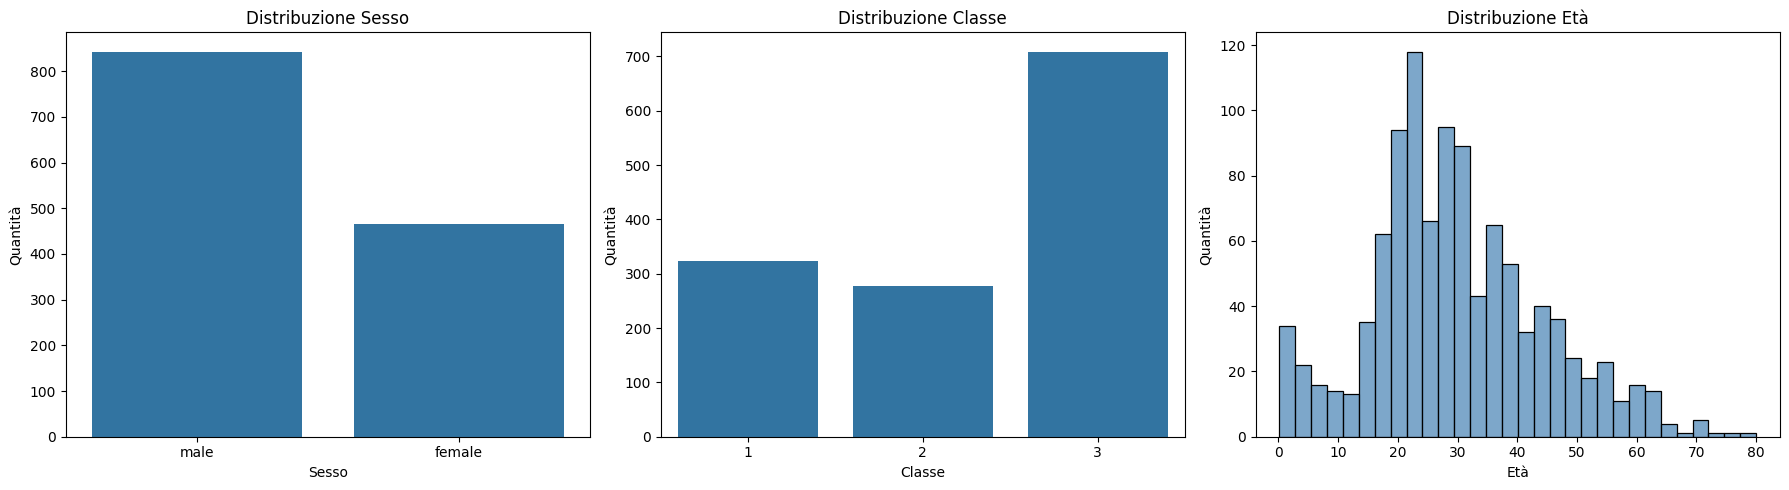

In [178]:
test_df = pd.read_csv('dataset/test.csv')

df = pd.concat([train_df, test_df], ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='Sex', data=df, ax=axes[0])
axes[0].set_title('Distribuzione Sesso')
axes[0].set_xlabel('Sesso')
axes[0].set_ylabel('Quantità')


sns.countplot(x='Pclass', data=df, ax=axes[1])
axes[1].set_title('Distribuzione Classe')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Quantità')


sns.histplot(df['Age'].dropna(), bins=30, kde=False, ax=axes[2], color='steelblue', alpha=0.7)
axes[2].set_title('Distribuzione Età')
axes[2].set_xlabel('Età')
axes[2].set_ylabel('Quantità')

plt.tight_layout()
plt.show()





Da questi grafici, è possibile intuire che i passeggeri maschili di terza classe, tra i 18-36 anni, siano una componente significativa della popolazione. Verifichiamo l'ipotesi andando a rappresentare il rapporto tra questi tre parametri.

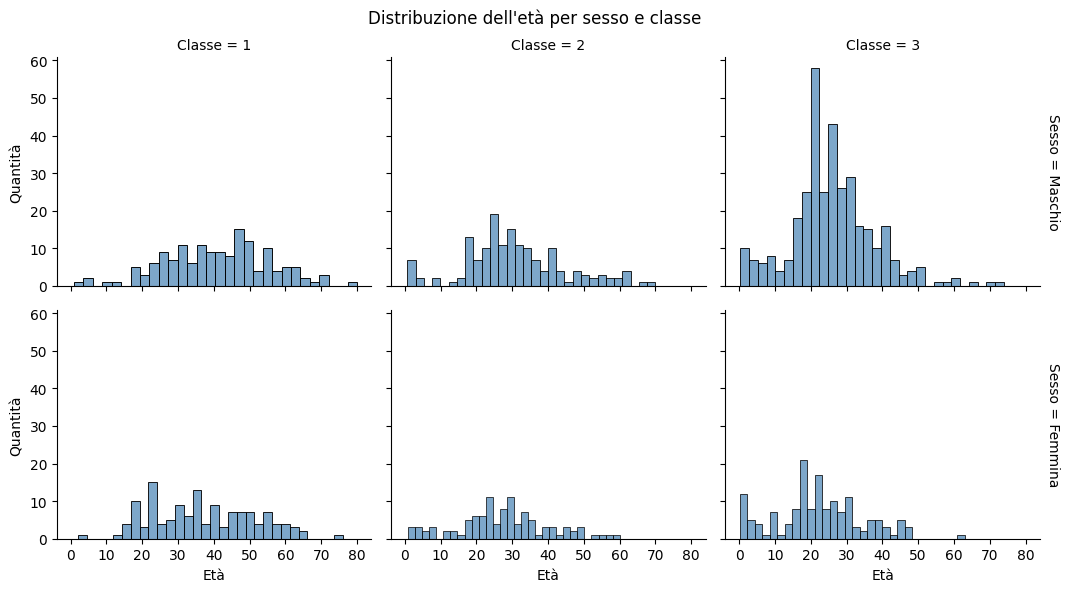

In [179]:
df_plot = df.copy()
df_plot['Sesso'] = df_plot['Sex'].map({'male': 'Maschio', 'female': 'Femmina'})
df_plot['Classe'] = df_plot['Pclass']

g = sns.FacetGrid(df_plot, row="Sesso", col="Classe", margin_titles=True, height=3, aspect=1.2)
g.map(sns.histplot, "Age", bins=30, color="steelblue", alpha=0.7, kde=False)
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(0, 85, 10))
    ax.set_xlabel("Età")
    ax.set_ylabel("Quantità")
plt.subplots_adjust(top=0.9)
g.figure.suptitle("Distribuzione dell'età per sesso e classe")
plt.show()

Come abbiamo ipotizzato, i maschi di terza classe sono una componente significativa del nostro dataset. Visualizzaiamo anche la distribuzione dei superstiti secondo questi campi.  
Si noti che il grafico successivo, data l'assenza del campo *Survived* nel dataset di testing, avrà un numero minore di entry rispetto al grafico di sopra.

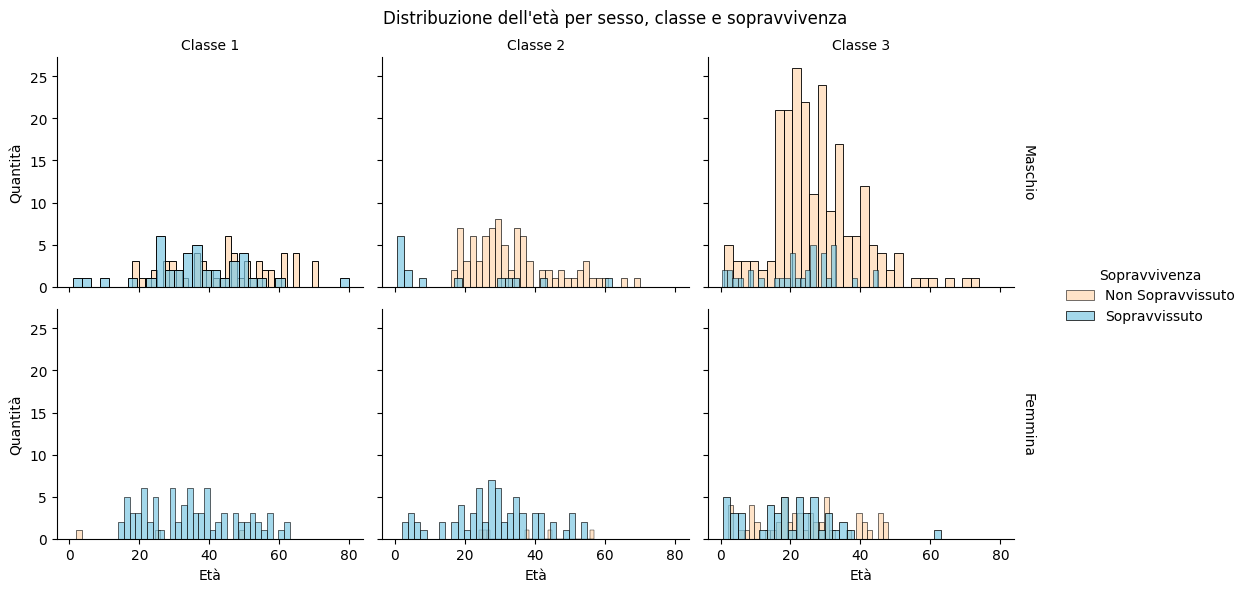

In [180]:
df_plot = df.dropna(subset=['Survived', 'Age']).copy()
df_plot['Survived'] = df_plot['Survived'].map({0: 'Non Sopravvissuto', 1: 'Sopravvissuto'})
df_plot['Sesso'] = df_plot['Sex'].map({'male': 'Maschio', 'female': 'Femmina'})
survival_palette = {'Sopravvissuto': '#7ec8e3', 'Non Sopravvissuto': '#ffd8b1'}

g = sns.FacetGrid(
    df_plot,
    row="Sesso",
    col="Pclass",
    hue="Survived",
    margin_titles=True,
    height=3,
    aspect=1.2,
    palette=survival_palette
)
g.map(sns.histplot, "Age", bins=30, alpha=0.7, kde=False)
g.set_axis_labels("Età", "Quantità")
g.set_titles(row_template='{row_name}', col_template='Classe {col_name}')
g.add_legend(title="Sopravvivenza")
plt.subplots_adjust(top=0.9)
g.figure.suptitle("Distribuzione dell'età per sesso, classe e sopravvivenza")
plt.show()

Notiamo che la popolazione femminile abbia un tasso di sopravvivenza maggiore di quella maschile indipendentemente dalla classe, mentre la popolazione maschile di terza classe è quella con il tasso di sopravvivenza più basso. Rappresentiamo il valore percentuale di ogni gruppo per rendere più evidente la relazione.

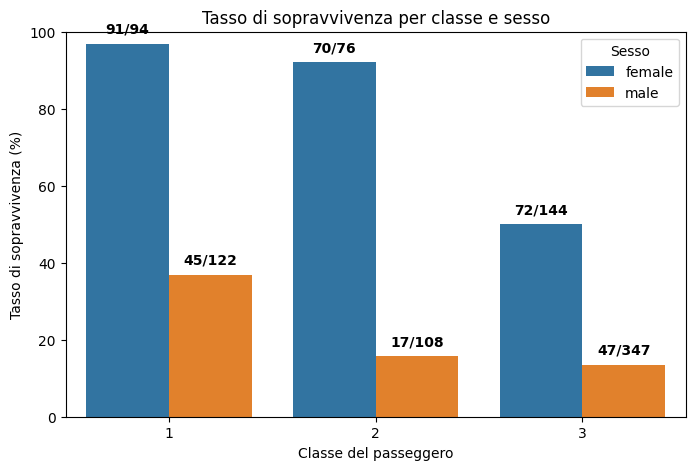

In [181]:
survival_stats = (
    df.dropna(subset=['Survived'])
      .groupby(['Sex', 'Pclass'])['Survived']
      .agg(['mean', 'sum', 'count'])
      .reset_index()
)
survival_stats['SurvivalRate'] = survival_stats['mean'] * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=survival_stats,
    x='Pclass',
    y='SurvivalRate',
    hue='Sex'
)
plt.ylabel('Tasso di sopravvivenza (%)')
plt.xlabel('Classe del passeggero')
plt.title('Tasso di sopravvivenza per classe e sesso')
plt.ylim(0, 100)
plt.legend(title='Sesso')

for bar, (_, group) in zip(ax.patches, survival_stats.iterrows()):
    survivors = int(group['sum'])
    total = int(group['count'])
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{survivors}/{total}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.show()

Risulta evidente che sesso, età e classe di appartenenza siano rilevante per la determinazione della sopravvivenza o meno del passeggero.  
Proseguiamo ora ad analizzare la feature *Fare*. Con molta probabilità, questa feature sarà dipendente dalla classe di appartenenza, quindi grafichiamo direttamente il rapporto tra prezzo e classe.

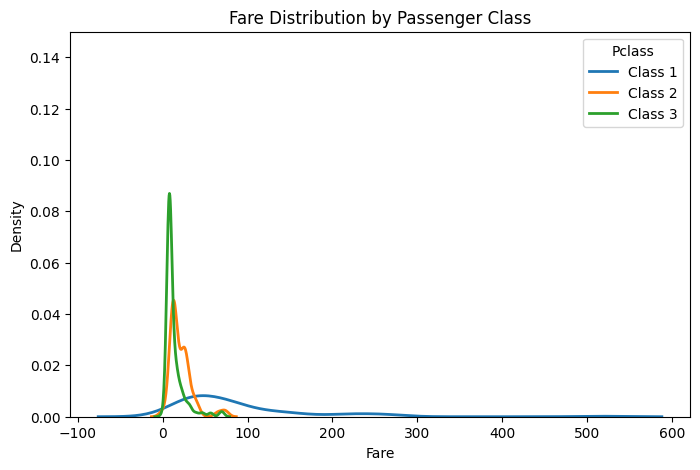

In [182]:
plt.figure(figsize=(8, 5))
for pclass in sorted(df['Pclass'].unique()):
    sns.kdeplot(
        df[df['Pclass'] == pclass]['Fare'].dropna(),
        label=f'Class {pclass}',
        linewidth=2
    )
plt.xlabel('Fare')
plt.ylabel('Density')
plt.title('Fare Distribution by Passenger Class')
plt.ylim(0, 0.15)
plt.legend(title='Pclass')
plt.show()

Come prevedibile, la terza classe presenta un picco elevato negli intorni di 5-10 per via della elevata popolazione all'interno del dataset, mentre il prezzo di un biglietto di seconda e terza classe risulta maggiore.  
Può essere interessante verificare se i campi *SibSp* e *ParCh* influiscano sul prezzo del biglietto. Per verificare ciò, andiamo ad introdurre una nuova feature chiamata *FamilySize*, data dalla somma delle due feature precedenti.

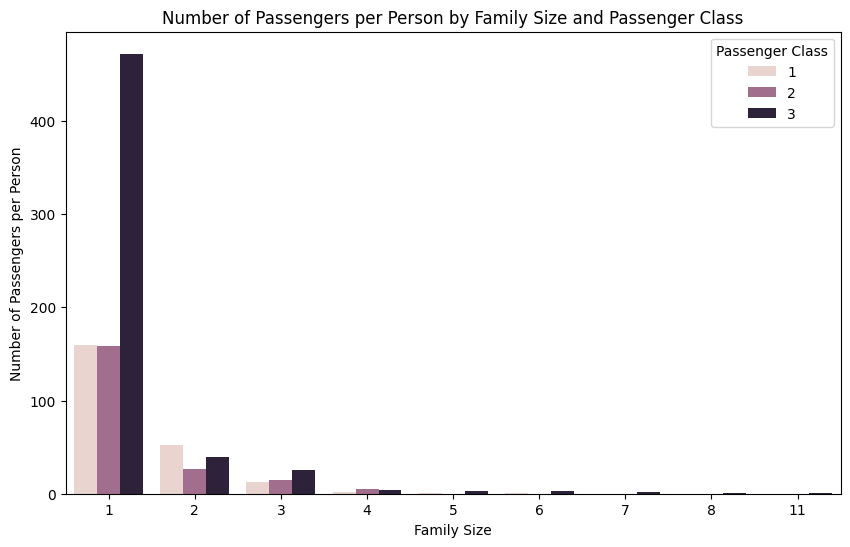

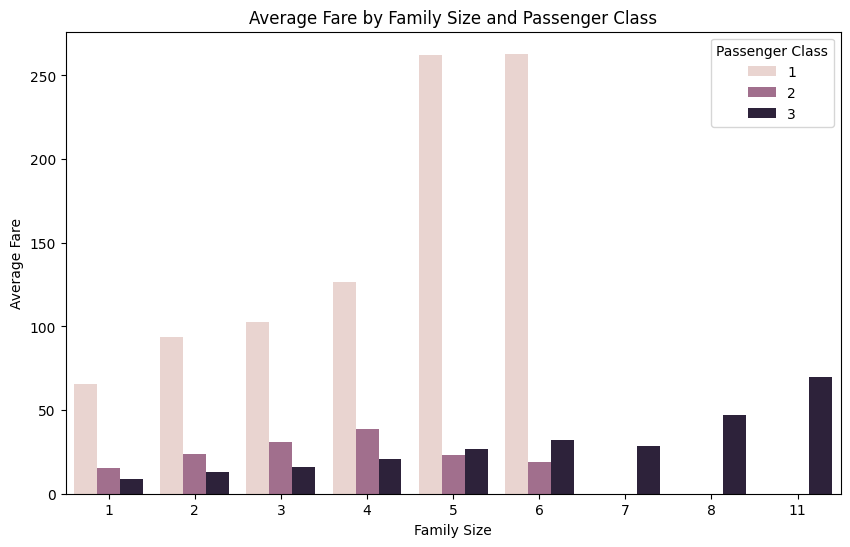

In [183]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # +1 per includere il passeggero stesso

df_plot = df.groupby(['FamilySize', 'Pclass']).size().reset_index(name='Count')
df_plot['CountPerPerson'] = df_plot['Count'] / df_plot['FamilySize']
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='FamilySize', y='CountPerPerson', hue='Pclass')
plt.title('Number of Passengers per Person by Family Size and Passenger Class')
plt.ylabel('Number of Passengers per Person')
plt.xlabel('Family Size')
plt.legend(title='Passenger Class')
plt.show()

fare_by_family = (
    df.groupby(['FamilySize', 'Pclass'])['Fare']
      .mean()
      .reset_index()
)
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=fare_by_family, x='FamilySize', y='Fare', hue='Pclass')
plt.title('Average Fare by Family Size and Passenger Class')
plt.ylabel('Average Fare')
plt.xlabel('Family Size')
plt.legend(title='Passenger Class')

plt.show()

Come ipotizzato, il prezzo medio di un biglietto di prima classe è maggiore rispetto le altre due classi, ed il prezzo del biglietto è proporzionale alla dimensione della famiglia. Vista la correlazione tra tasso di sopravvivenza e classe, è probabile che anche il campo FamilySize possa essere correlato con la sopravvivenza.

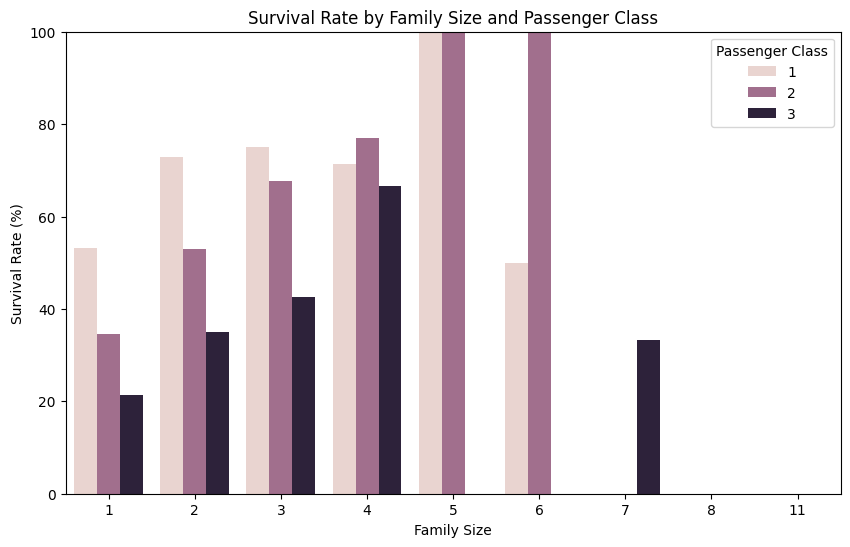

In [184]:
survival_by_family = (
    df.dropna(subset=['Survived'])
      .groupby(['FamilySize', 'Pclass'])['Survived']
      .mean()
      .reset_index()
)
survival_by_family['Survived'] = survival_by_family['Survived'] * 100
plt.figure(figsize=(10, 6))
sns.barplot(data=survival_by_family, x='FamilySize', y='Survived', hue='Pclass')
plt.title('Survival Rate by Family Size and Passenger Class')
plt.ylabel('Survival Rate (%)')
plt.xlabel('Family Size')
plt.legend(title='Passenger Class')
plt.ylim(0, 100)
plt.show()

Si noti che, all'aumentare della dimensione di una famiglia, è molto probabile aumenti il numero di donne e bambini: ciò comporta un aumento della probabilità di sopravvivenza dovuto al maggior tasso di sopravvivenza delle categorie citate.  
Analizziamo ora la feature *Embarked* in relazione alla classe.

C:\Users\Astolfo\AppData\Local\Temp\ipykernel_5192\2099723006.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([embarked_labels.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])


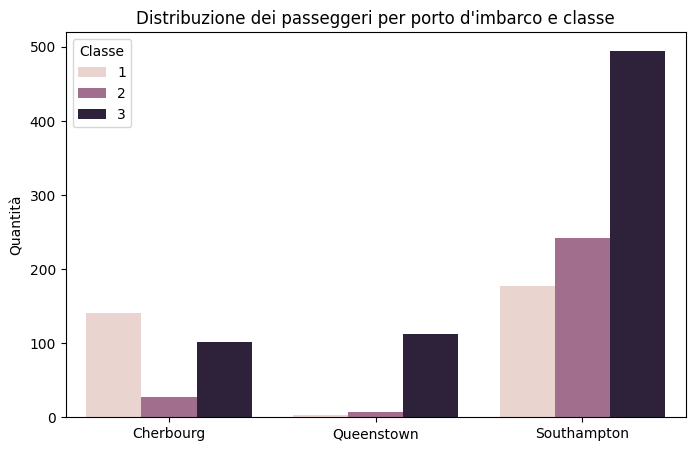

In [185]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Embarked', hue='Pclass', order=['C', 'Q', 'S'])
plt.xlabel('')
plt.ylabel('Quantità')
plt.title('Distribuzione dei passeggeri per porto d\'imbarco e classe')
plt.legend(title='Classe')

embarked_labels = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}
ax = plt.gca()
ax.set_xticklabels([embarked_labels.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])
plt.show()

La maggior parte dei passeggeri si sono imbarcati a Southampton, mentre metà dei passeggeri di prima classe si sono imbarcati al porto di Cherbourg. Se rappresentiamo il tasso di sopravvivenza in base al porto, quest'ultimo avrà il valore maggiore.

C:\Users\Astolfo\AppData\Local\Temp\ipykernel_5192\1169139005.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


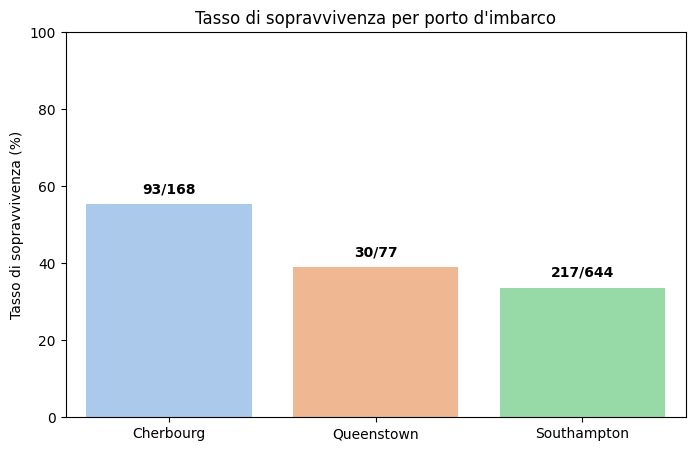

In [186]:
embarked_survival = (
    df.dropna(subset=['Survived', 'Embarked'])
      .groupby('Embarked')['Survived']
      .agg(['mean', 'sum', 'count'])
      .reset_index()
)
embarked_survival['Survived'] = embarked_survival['mean'] * 100
embarked_survival['EmbarkedFull'] = embarked_survival['Embarked'].map(embarked_labels)

plt.figure(figsize=(8, 5))
order = ['Cherbourg', 'Queenstown', 'Southampton']
ax = sns.barplot(
    data=embarked_survival,
    x='EmbarkedFull',
    y='Survived',
    order=order,
    palette='pastel'
)
plt.ylabel('Tasso di sopravvivenza (%)')
plt.xlabel('')
plt.title('Tasso di sopravvivenza per porto d\'imbarco')
plt.ylim(0, 100)

for i, row in embarked_survival.set_index('EmbarkedFull').loc[order].reset_index().iterrows():
    survived = int(row['sum'])
    total = int(row['count'])
    ax.text(i, row['Survived'] + 2, f"{survived}/{total}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

Visto che la probabilità di sopravvivenza è dovuta alla classe rispetto al porto di appartenenza, questa feature verrà trascurata per addestrare il modello.  
L'analisi delle cabine risulta più complessa visto l'elevato numero di valori mancanti. Secondo fonti online, le cabine di prima, seconda e terza classe erano distribuite su ponti diversi della nave. Il Titanic presentava 8 ponti al di sopra della linea di galleggiamento, identificati dalla lettera *A* alla *G*, più un ponte superiore al ponte *A* comunemente definito *Boat Deck* in quanto ospitava le scialuppe. I vari ponti ospitavano cabine diverse:  
- **A-B-C** erano occupati esclusivamente da cabine di prima classe  
- **D-E** da cabine di tutte le classi  
- **F-G** da cabine di seconda e terza classe
- **Boat Deck** ospitava 6 cabine destinate alla prima classe, nominate *T*, *U*, *W*, *X*, *Y*, *Z*. Soltanto la cabina *T* era occupata

![image.png](https://media.discordapp.net/attachments/1332005221705973833/1387809484759629874/image.png?ex=685eb1cd&is=685d604d&hm=9cc6d2725f141c71ac1fdf4948fbfa687d9f26663785ae9e3d691eda91293e95&=&format=webp&quality=lossless&width=1278&height=889)  

Le cabine erano numerate in base al ponte della nave, quindi in base al valore di *Cabin* possiamo ricavare su quale ponte si trovasse il passeggero.  

https://www.encyclopedia-titanica.org/titanic-deckplans

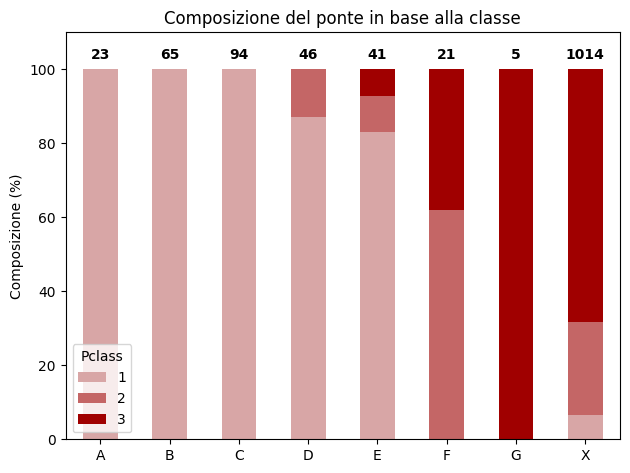

In [187]:
# il passeggero della cabina T, vista la somiglianza con il ponte A, lo assegno a quest'ultimo
df['Deck'] = df['Cabin'].apply(lambda x: 'A' if pd.notna(x) and x[0] == 'T' else (x[0] if pd.notna(x) else 'X'))


deck_pclass_counts = df.groupby(['Deck', 'Pclass']).size().unstack(fill_value=0)
deck_totals = deck_pclass_counts.sum(axis=1)
deck_pclass_percent = deck_pclass_counts.divide(deck_totals, axis=0) * 100
pclass_colors = {1: '#d8a6a6', 2: '#c46666', 3: '#a00000'}
colors = [pclass_colors[p] for p in sorted(deck_pclass_percent.columns)]
ax = deck_pclass_percent.plot(kind='bar', stacked=True, color=colors)
plt.ylabel('Composizione (%)')
plt.xlabel('')
plt.title('Composizione del ponte in base alla classe')
plt.tight_layout()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for i, (deck, total) in enumerate(deck_totals.items()):
    ax.text(i, 102, f'{total}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, 110)
plt.show()

I passeggeri di cui non conosciamo la cabina sono in larga parte di terza classe. Può essere utile visualizzare il tasso di sopravvivenza di ogni ponte.

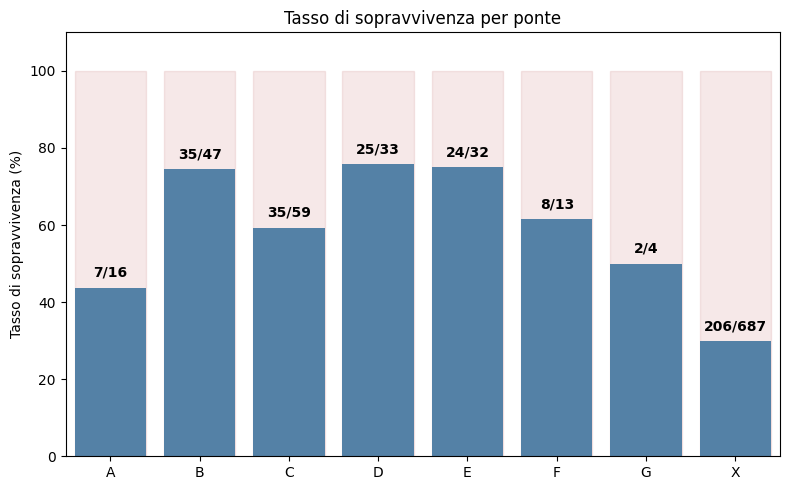

In [188]:
survival_rate_per_deck = df.groupby('Deck')['Survived'].mean() * 100
survival_rate_per_deck = survival_rate_per_deck.sort_index()
deck_counts = df.groupby('Deck')['Survived'].agg(['sum', 'count']).loc[survival_rate_per_deck.index]

plt.figure(figsize=(8, 5))
ax = plt.gca()
for i, deck in enumerate(survival_rate_per_deck.index):
    ax.add_patch(
        plt.Rectangle((i - 0.4, 0), 0.8, 100, color='#c46666', alpha=0.15, zorder=0)
    )

bars = sns.barplot(x=survival_rate_per_deck.index, y=survival_rate_per_deck.values, color="steelblue", zorder=1, ax=ax)
plt.ylabel('Tasso di sopravvivenza (%)')
plt.xlabel('')
plt.title('Tasso di sopravvivenza per ponte')
plt.ylim(0, 110)
plt.tight_layout()

for i, (deck, rate) in enumerate(survival_rate_per_deck.items()):
    survivors = int(deck_counts.loc[deck, 'sum'])
    total = int(deck_counts.loc[deck, 'count'])
    bar_height = rate
    ax.text(i, bar_height + 2, f"{survivors}/{total}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

Si noti che il tasso di sopravvivenza, in quanto percentuale, risulta essere *misleading*: il ponte *G*, nonostante composto da soli passeggeri di terza classe, presenta una sopravvivenza maggiore rispetto il ponte *A*, composto da passeggeri di prima classe. Ciò è dovuto al ridotto numero di passeggeri di cui abbiamo la certezza fossero situati sul ponte *G*. Se andiamo ad analizzare un ponte composto da più classi, noteremo che la terza classe presenta lo stesso un *survival rate* minore delle altre classi. In seguito, è rappresentato il ponte *F*.

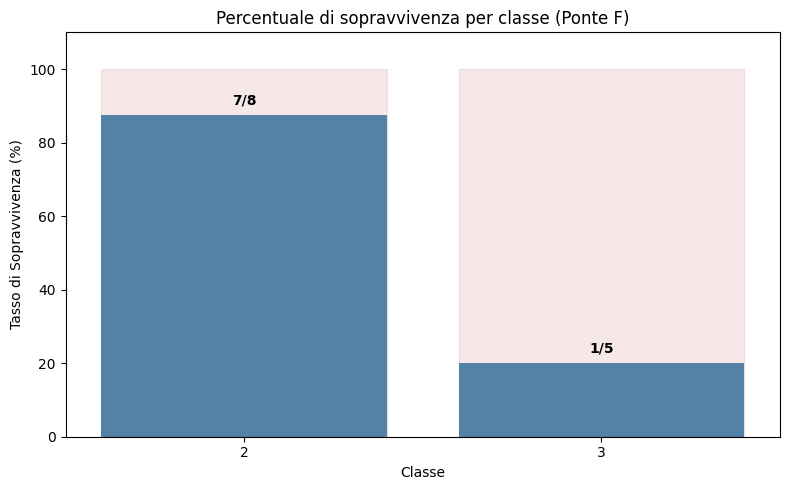

In [189]:
deck_f = df[df['Deck'] == 'F']
survival_f_pclass = deck_f.groupby('Pclass')['Survived'].mean() * 100
survival_f_pclass = survival_f_pclass.sort_index()
counts_f = deck_f.groupby('Pclass')['Survived'].agg(['sum', 'count']).loc[survival_f_pclass.index]

plt.figure(figsize=(8, 5))
ax = plt.gca()

for i, pclass in enumerate(survival_f_pclass.index):
    ax.add_patch(
        plt.Rectangle((i - 0.4, 0), 0.8, 100, color='#c46666', alpha=0.15, zorder=0)
    )

sns.barplot(x=survival_f_pclass.index, y=survival_f_pclass.values, color="steelblue", ax=ax, zorder=1)
plt.ylabel('Tasso di Sopravvivenza (%)')
plt.xlabel('Classe')
plt.title('Percentuale di sopravvivenza per classe (Ponte F)')
plt.tight_layout()

for i, (pclass, row) in enumerate(counts_f.iterrows()):
    survivors = int(row['sum'])
    total = int(row['count'])
    ax.text(i, survival_f_pclass.iloc[i] + 2, f"{survivors}/{total}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, 110)
plt.show()

Il ponte *X* è quello con tasso di sopravvivenza minore rispetto agli altri. Visto che è occupato da passeggeri di tutte le classi, è opportuno verificare il tasso di sopravvivenza di ognuna.

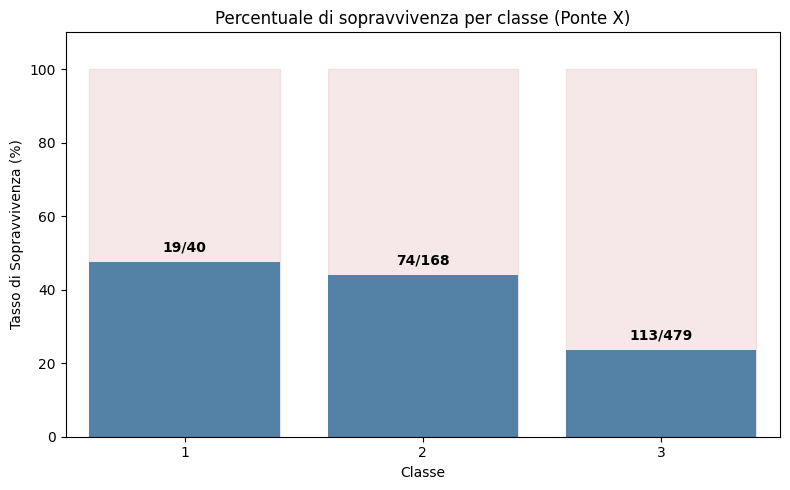

In [190]:
deck_x = df[df['Deck'] == 'X']
survival_pclass = deck_x.groupby('Pclass')['Survived'].mean() * 100
survival_pclass = survival_pclass.sort_index()
counts = deck_x.groupby('Pclass')['Survived'].agg(['sum', 'count']).loc[survival_pclass.index]

plt.figure(figsize=(8, 5))
ax = plt.gca()

for i, pclass in enumerate(survival_pclass.index):
    ax.add_patch(
        plt.Rectangle((i - 0.4, 0), 0.8, 100, color='#c46666', alpha=0.15, zorder=0)
    )

sns.barplot(x=survival_pclass.index, y=survival_pclass.values, color="steelblue", ax=ax, zorder=1)
plt.ylabel('Tasso di Sopravvivenza (%)')
plt.xlabel('Classe')
plt.title('Percentuale di sopravvivenza per classe (Ponte X)')
plt.tight_layout()

for i, (pclass, row) in enumerate(counts.iterrows()):
    survivors = int(row['sum'])
    total = int(row['count'])
    ax.text(i, survival_pclass.iloc[i] + 2, f"{survivors}/{total}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, 110)
plt.show()

In linea con ciò che abbiamo verificato in precedenza, i passeggeri di terza classe presentano sempre un tasso di sopravvivenza minore rispetto le altre.  
Proseguendo, la feature *Name*, per quanto è evidente non abbia alcuna relazione con la probabilità di sopravvivenza, può comunque fornirci un indicatore sullo stato sociale dei vari passeggeri tramite il titolo. 

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Mme               1
Don               1
Sir               1
Lady              1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64


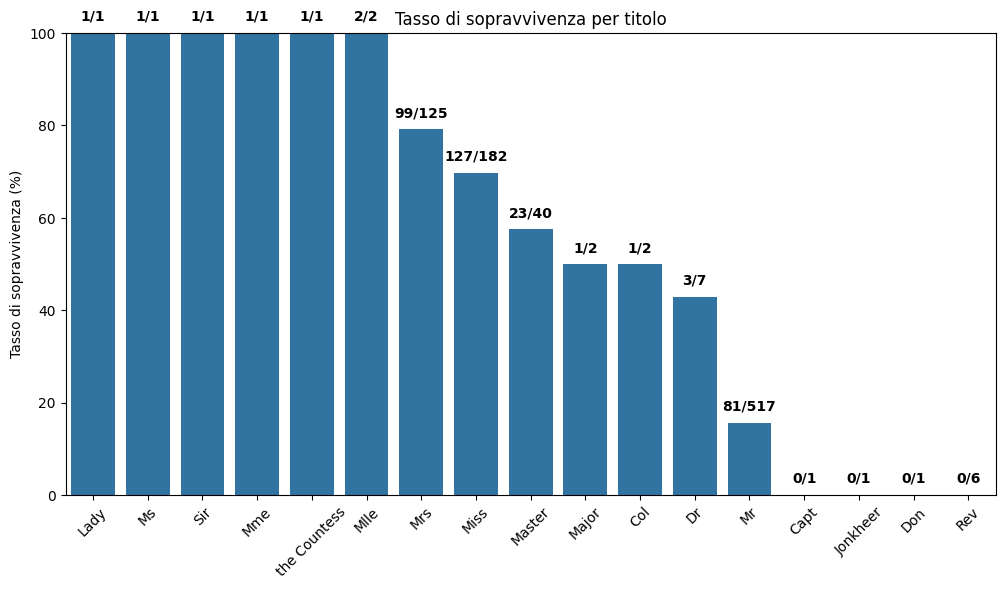

In [191]:
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
print(df['Title'].value_counts())

title_survival = (
    df.dropna(subset=['Survived'])
      .groupby('Title')['Survived']
      .agg(['mean', 'sum', 'count'])
      .reset_index()
)
title_survival['Survived'] = title_survival['mean'] * 100

plt.figure(figsize=(12, 6))
order = title_survival.sort_values('Survived', ascending=False)['Title']
ax = sns.barplot(
    data=title_survival,
    x='Title',
    y='Survived',
    order=order
)
plt.ylabel('Tasso di sopravvivenza (%)')
plt.xlabel('')
plt.title('Tasso di sopravvivenza per titolo')
plt.ylim(0, 100)
plt.xticks(rotation=45)

for i, row in title_survival.set_index('Title').loc[order].reset_index().iterrows():
    survived = int(row['sum'])
    total = int(row['count'])
    ax.text(i, row['Survived'] + 2, f"{survived}/{total}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

Notiamo che titoli nobiliari e femminili presentino un tasso di sopravvivenza maggiore rispetto gli altri, in linea con quello che abbiamo concluso con le analisi precedenti.

---  

### Preprocessing

In [192]:
print(df.info())
print(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  FamilySize   1309 non-null   int64  
 13  Deck         1309 non-null   object 
 14  Title        1309 non-null   object 
dtypes: float64(3), int64(5), object(7)
memory usage: 153.5+ KB
None
   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2 

Trascurando i "Survived" mancanti per le entry del dataset di test, procediamo a gestire i parametri mancanti.  
Iniziando dalla colonna "Embarked", sono assenti solo due valori per le seguente passeggere:

In [193]:
print(df[df['Embarked'].isna()])

     PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  FamilySize Deck  \
61   female  38.0      0      0  113572  80.0   B28      NaN           1    B   
829  female  62.0      0      0  113572  80.0   B28      NaN           1    B   

    Title  
61   Miss  
829   Mrs  


Notiamo che le due condividono cabina, identificativo e prezzo del biglietto, il che implica che si siano imbarcate allo stesso porto. Tramite una ricerca, riscontriamo che Amelie Icard era la domestica di Martha Evelyn Stone, ed entrambe si sono imbarcate al porto di Southampton.

In [194]:
df.loc[df['PassengerId'] == 830, 'Embarked'] = 'S'
df.loc[df['PassengerId'] == 62, 'Embarked'] = 'S'

Per la gestione delle età mancanti, in linea con quello che abbiamo riscontrato nell'analisi precedente, bisogna prestare attenzione alla classe ed al sesso del passeggero. Assegneremo a tutti i passeggeri con età mancante, l'età mediana in base al suo sesso e classe.

In [195]:
median_ages = df.groupby(['Sex', 'Pclass'])['Age'].median()
df['Age'] = df.apply(
    lambda row: median_ages[row['Sex'], row['Pclass']] if pd.isna(row['Age']) else row['Age'],
    axis=1
)

Passiamo ora alla gestione del Fare. Una singola entry ha il valore mancante, corrispondente ad un maschio di terza classe che viaggia da solo.

In [196]:
print(df[df['Fare'].isna()])

      PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

      Parch Ticket  Fare Cabin Embarked  FamilySize Deck Title  
1043      0   3701   NaN   NaN        S           1    X    Mr  


Per assegnargli il fare più opportuno, possiamo ricavare il prezzo mediano di tutti i maschi nella sue stesse circostanze, ovvero passeggeri di terza classe solitari.

In [197]:
df.loc[df['PassengerId'] == 1044, 'Fare'] = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
print(df[df['PassengerId'] == 1044]['Fare'])

1043    7.8542
Name: Fare, dtype: float64


Cercando in archivi online, risulta che il prezzo effettivo del suo biglietto era di 7£, sufficentemente vicino a quello stimato.  
La gestione delle cabine mancanti non è necessaria in quanto abbiamo deciso di analizzare il ponte di appartenenza.

--- 

### Feature Encoding  

Iniziamo a preparare il dataset per l'addestramento del modello. In primo luogo, droppiamo le colonne che non ci saranno utili.

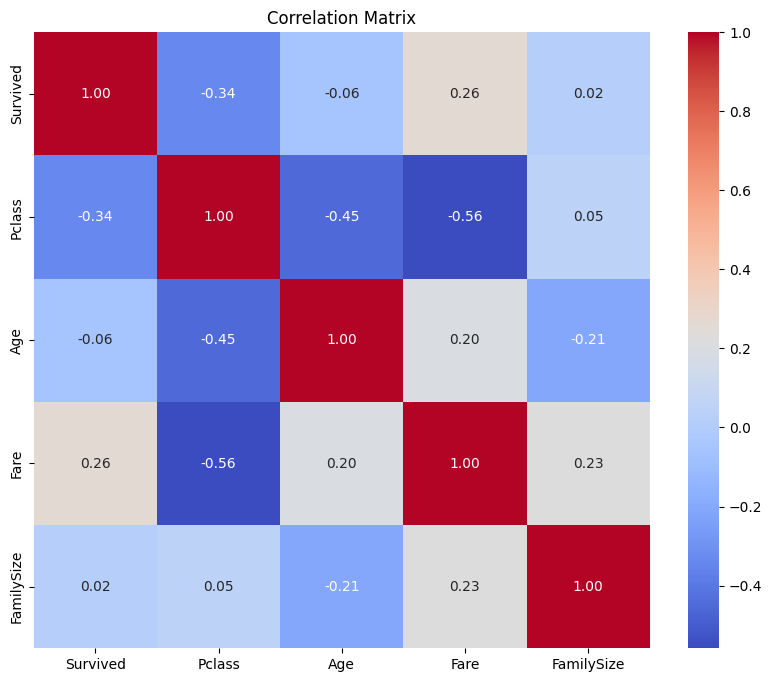

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Sex         1309 non-null   object 
 3   Age         1309 non-null   float64
 4   Fare        1309 non-null   float64
 5   FamilySize  1309 non-null   int64  
 6   Deck        1309 non-null   object 
 7   Title       1309 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 81.9+ KB
None


In [198]:
df=df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin', 'SibSp', 'Parch'])

plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

print(df.info())

Proseguiamo ad effettuare l'encoding delle feature numeriche.

In [199]:
le = LabelEncoder()

# prima eseguiamo il binning delle feature numeriche in 10 bin separate
df['Fare'] = pd.qcut(df['Fare'], 10)
df['Age'] = pd.qcut(df['Age'], 10)

# poi eseguiamo l'encoding dei vari bin
df['Fare'] = le.fit_transform(df['Fare'].astype(str))
df['Age'] = le.fit_transform(df['Age'].astype(str))

# l'encoding delle famiglie è svolto manualmente
def bin_family_size(size):
    if size == 1:
        return 0  # solo
    elif 2 <= size <= 4:
        return 1  # piccola
    elif 5 <= size <= 8:
        return 2  # media
    else:
        return 3  # grande

df.loc[:, 'FamilySize'] = df['FamilySize'].apply(bin_family_size)
df = pd.get_dummies(df, columns=['FamilySize'], prefix='FamilySize')

"Normalizziamo" il titolo dei passeggeri in base alla "categoria": la scelta della categoria è stata definita in base alla probabilità di sopravvivenza dei vari titoli:  
- **Miss** per titoli femminili  
- **Mr** per titoli maschili
- **Nobility** per titoli nobiliari
- **Clergy** per titoli ecclesiastici
- **Special** per militari e medici.  

Si noti, il titolo *Master* verso l'inizio del XX secolo, veniva utilizzato per riferirsi a bambini; *Clergy* è stato tenuto separato dalle altre categorie in quanto, a differenza dei titoli nobiliari e militari/medici, presentano un tasso di sopravvivenza nullo; *Special* include sia titoli militari che medici, in quanto il tasso di sopravvivenza per loro risulta molto simile

In [200]:
df['Title'] = df['Title'].replace(
    {
        'Mrs': 'Miss',
        'Ms': 'Miss',
        'Mlle': 'Miss',
        'Mme': 'Miss',
        'Master': 'Mr',
        'Dona': 'Nobility',
        'Don': 'Nobility',
        'Jonkheer': 'Nobility',
        'the Countess': 'Nobility',
        'Lady': 'Nobility',
        'Sir': 'Nobility',
        'Rev': 'Clergy',
        'Col': 'Special',
        'Major': 'Special',
        'Capt': 'Special',
        'Dr': 'Special'
    }
)

print(df['Title'].value_counts())

Title
Mr          818
Miss        462
Special      15
Clergy        8
Nobility      6
Name: count, dtype: int64


In [201]:
# one-hot encoding delle feature categoriche

df = pd.get_dummies(df, columns=['Pclass', 'Deck'], prefix=['Pclass', 'Deck'])
df.loc[:, 'Sex'] = df['Sex'].map({'male': 1, 'female': 0})
df = pd.get_dummies(df, columns=['Title'], prefix='Title')

print(df.head(1))

   Survived Sex  Age  Fare  FamilySize_0  FamilySize_1  FamilySize_2  \
0       0.0   1    2     0         False          True         False   

   FamilySize_3  Pclass_1  Pclass_2  ...  Deck_D  Deck_E  Deck_F  Deck_G  \
0         False     False     False  ...   False   False   False   False   

   Deck_X  Title_Clergy  Title_Miss  Title_Mr  Title_Nobility  Title_Special  
0    True         False       False      True           False          False  

[1 rows x 24 columns]


Visto che le informazioni del campo *Title* sono già implicate da altri fattori, la presenza o meno di questo campo influenzerà in maniera marginale il modello. Procederemo all'addestramento di due modelli diversi, uno con e l'altro senza la feature *Title*.

In [205]:
df_with_title = df.copy()
df_without_title = df.drop(columns=['Title_Clergy', 'Title_Miss', 'Title_Mr', 'Title_Nobility', 'Title_Special'])

df_with_title_train = df_with_title[df_with_title['Survived'].notna()]
df_with_title_test = df_with_title[df_with_title['Survived'].isna()]
df_with_title_test = df_with_title_test.drop(columns=['Survived'])

df_without_title_train = df_without_title[df_without_title['Survived'].notna()]
df_without_title_test = df_without_title[df_without_title['Survived'].isna()]
df_without_title_test = df_without_title_test.drop(columns=['Survived'])


df_with_title_train.to_csv('dataset/train_processed_alt.csv', index=False)
df_with_title_test.to_csv('dataset/test_processed_alt.csv', index=False)

df_without_title_train.to_csv('dataset/train_processed.csv', index=False)
df_without_title_test.to_csv('dataset/test_processed.csv', index=False)
                                   

---  

### Addestramento dei Modelli  

Addestriamo vari tipi di classificatori per riscontrare quale abbia le prestazioni migliori.


Random Forest
Confusion Matrix:
[[108  26]
 [ 19  70]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       134
         1.0       0.73      0.79      0.76        89

    accuracy                           0.80       223
   macro avg       0.79      0.80      0.79       223
weighted avg       0.80      0.80      0.80       223

Confusion Matrix:
[[108  26]
 [ 19  70]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       134
         1.0       0.73      0.79      0.76        89

    accuracy                           0.80       223
   macro avg       0.79      0.80      0.79       223
weighted avg       0.80      0.80      0.80       223



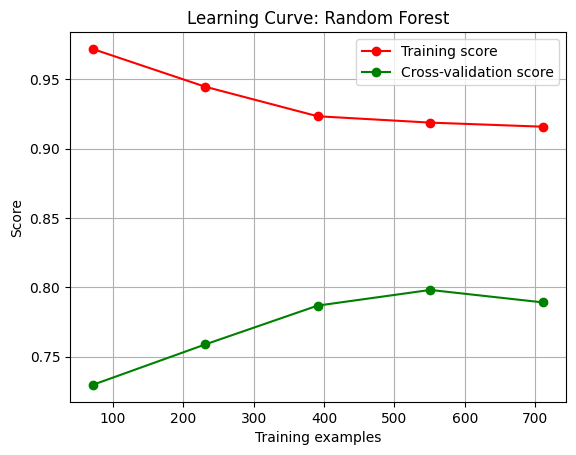


Logistic Regression
Confusion Matrix:
[[116  18]
 [ 23  66]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       134
         1.0       0.79      0.74      0.76        89

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



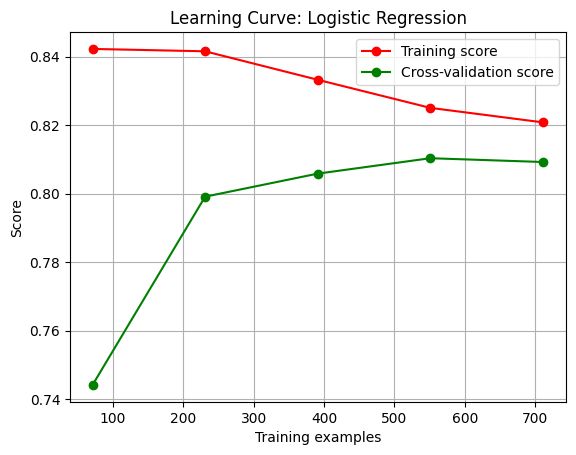


Support Vector Machine
Confusion Matrix:
[[111  23]
 [ 26  63]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       134
         1.0       0.73      0.71      0.72        89

    accuracy                           0.78       223
   macro avg       0.77      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



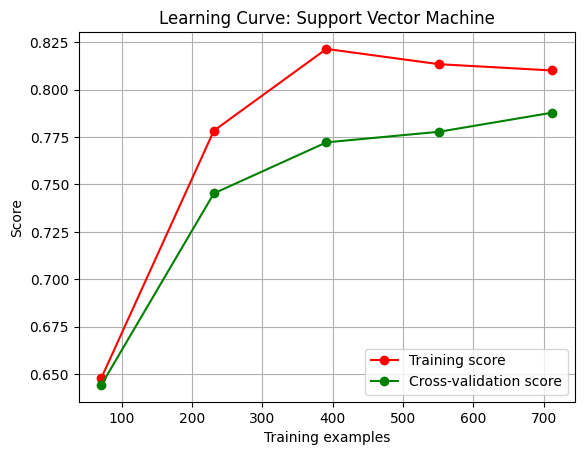


Decision Tree
Confusion Matrix:
[[111  23]
 [ 22  67]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       134
         1.0       0.74      0.75      0.75        89

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



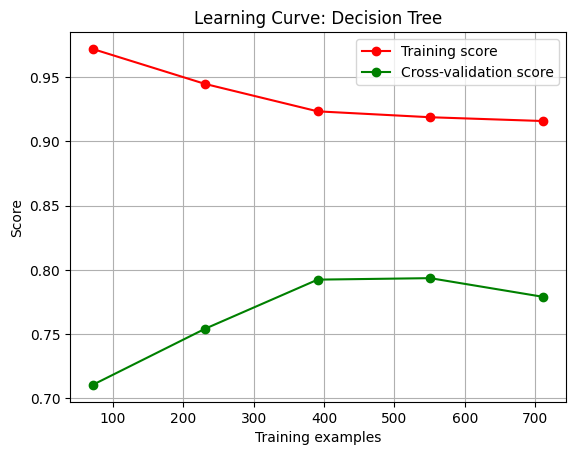


K-Nearest Neighbors
Confusion Matrix:
[[114  20]
 [ 22  67]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       134
         1.0       0.77      0.75      0.76        89

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



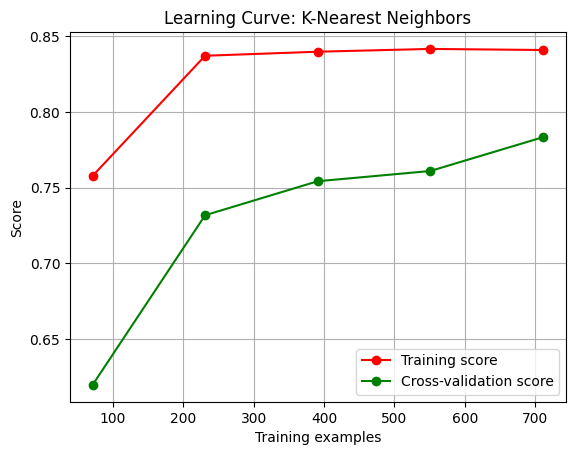


Gradient Boosting
Confusion Matrix:
[[113  21]
 [ 22  67]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       134
         1.0       0.76      0.75      0.76        89

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223

Confusion Matrix:
[[113  21]
 [ 22  67]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       134
         1.0       0.76      0.75      0.76        89

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



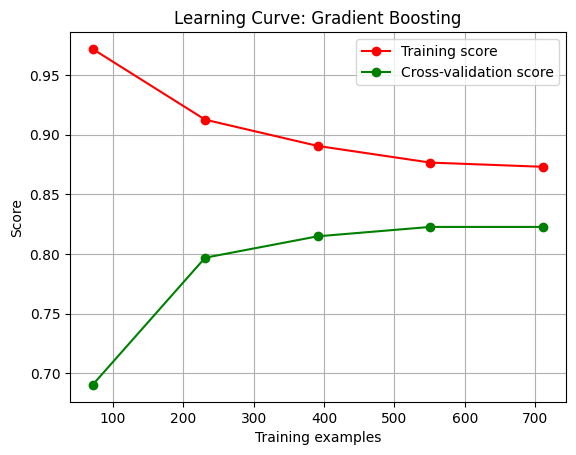


XGBoost
Confusion Matrix:
[[113  21]
 [ 23  66]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       134
         1.0       0.76      0.74      0.75        89

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223

Confusion Matrix:
[[113  21]
 [ 23  66]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       134
         1.0       0.76      0.74      0.75        89

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



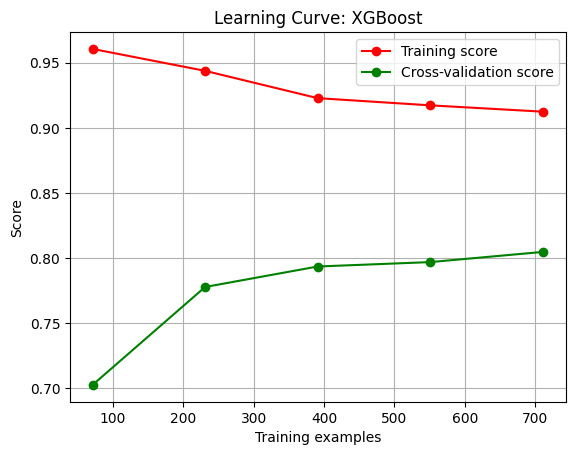

In [206]:
df = pd.read_csv('dataset/train_processed.csv')

X= df.drop(columns=['Survived'])
Y = df['Survived']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(Y_test, y_pred))
    print("Classification Report:")
    print(classification_report(Y_test, y_pred))

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, Y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

Il Regressore Logistico risulta avere una precisione marginalmente migliore rispetto gli altri modelli (82%), verifichiamo se è possibile migiorarlo ulteriormente tramite *hyperparameter tuning*.

In [208]:
search_space = {
    'C': (1e-3, 100.0, 'log-uniform'),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

opt = BayesSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    search_spaces=search_space,
    n_iter=32,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

opt.fit(X_train, Y_train)

print("Best Parameters Found:", opt.best_params_)
print("\nClassification Report on Test Set:")
print(classification_report(Y_test, opt.predict(X_test)))


Best Parameters Found: OrderedDict({'C': 0.3522154590284792, 'penalty': 'l2', 'solver': 'saga'})

Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87       134
         1.0       0.82      0.74      0.78        89

    accuracy                           0.83       223
   macro avg       0.83      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



Il modello migliora marginalmente con uno score dell'83%. Prevediamo ora sul dataset di testing per la consegna alla competizione.

In [209]:
test_df = pd.read_csv('dataset/test_processed.csv')
passegers_ids = pd.read_csv('dataset/test.csv')['PassengerId']

Y_test_final = opt.predict(test_df)


submission_df = pd.DataFrame({
    'PassengerId': passegers_ids,
    'Survived': Y_test_final
})

# il collega li vuole in int
submission_df['Survived'] = submission_df['Survived'].astype(int)
submission_df.to_csv('dataset/result/submission.csv', index=False)

Consegnando il file delle predizioni, il modello ha una precisione di ~78%

![Risultato submission su Kaggle](https://media.discordapp.net/attachments/1227331910577946686/1387842735452717226/image.png?ex=685ed0c5&is=685d7f45&hm=ee5c0bbe2cb03ad9c38ceb5bb494b7b1274272b159c6b954866a656d2d7e9105&=&format=webp&quality=lossless&width=324&height=106)

Provando ad addestrare il modello con il dataset che include i titoli:

In [210]:
test_df_alt = pd.read_csv('dataset/train_processed_alt.csv')

X = test_df_alt.drop(columns=['Survived'])
Y = test_df_alt['Survived']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


opt = BayesSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    search_spaces=search_space,
    n_iter=32,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

opt.fit(X_train, Y_train)

print("Best Parameters Found (with title):", opt.best_params_)
print("\nClassification Report on Test Set:")
print(classification_report(Y_test, opt.predict(X_test)))

test_df = pd.read_csv('dataset/test_processed_alt.csv')
passegers_ids = pd.read_csv('dataset/test.csv')['PassengerId']

Y_test_final = opt.predict(test_df)


submission_df = pd.DataFrame({
    'PassengerId': passegers_ids,
    'Survived': Y_test_final
})

# il collega li vuole in int
submission_df['Survived'] = submission_df['Survived'].astype(int)
submission_df.to_csv('dataset/result/submission_alt.csv', index=False)

Best Parameters Found (with title): OrderedDict({'C': 0.3818873287795822, 'penalty': 'l2', 'solver': 'saga'})

Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       134
         1.0       0.79      0.74      0.76        89

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



Il modello ha le stesse performance

![Risultato dataset alternativo](https://media.discordapp.net/attachments/1227331910577946686/1387844007526404177/image.png?ex=685ed1f4&is=685d8074&hm=b71b523c848bb2a4fa0a7a123c497c54a19ef881b2eedaef87ffe756eb9e9065&=&format=webp&quality=lossless&width=344&height=114)

---  
#### Bibliografia  

qui ci infilo i link, poi mettiamo tipo le citations idk  

kaggle  
https://www.kaggle.com/competitions/titanic/overview  

quelle senza Embarked  
https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html  

composizione dei ponti  
https://www.encyclopedia-titanica.org/titanic-deckplans  

"fonte" sul fatto che la lettera della cabina identifica il ponte  
https://www.ggarchives.com/OceanTravel/Titanic/01-PlanningBuildingLaunching/Decks-ComprehensiveDetails.html  